In [31]:
%matplotlib inline
import math
import numpy as np
from utils import to_dates
import QuantLib as ql
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("whitegrid")

In [7]:
eonia = ql.Eonia()

helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                         ql.Period(1, ql.Days), fixingDays,
                         ql.TARGET(), ql.Following, False, ql.Actual360())
    for rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)]
]

In [8]:
helpers += [
    ql.OISRateHelper(2, ql.Period(*tenor),
                     ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia)
    for rate, tenor in [(0.070, (1, ql.Weeks)), (0.069, (2, ql.Weeks)),
                        (0.078, (3, ql.Weeks)), (0.074, (1, ql.Months))]
]

In [9]:
helpers += [
    ql.DatedOISRateHelper(start_date, end_date, ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia)
    for rate, start_date, end_date in [
        ( 0.046, ql.Date(16,ql.January,2013), ql.Date(13,ql.February,2013)),
        ( 0.016, ql.Date(13,ql.February,2013), ql.Date(13,ql.March,2013)),
        (-0.007, ql.Date(13,ql.March,2013), ql.Date(10,ql.April,2013)),
        (-0.013, ql.Date(10,ql.April,2013), ql.Date(8,ql.May,2013)),
        (-0.014, ql.Date(8,ql.May,2013), ql.Date(12,ql.June,2013))
    ]
]

In [10]:
helpers += [
    ql.OISRateHelper(2, ql.Period(*tenor),
                     ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia)
    for rate, tenor in [(0.002, (15,ql.Months)), (0.008, (18,ql.Months)),
                        (0.021, (21,ql.Months)), (0.036, (2,ql.Years)),
                        (0.127, (3,ql.Years)), (0.274, (4,ql.Years)),
                        (0.456, (5,ql.Years)), (0.647, (6,ql.Years)),
                        (0.827, (7,ql.Years)), (0.996, (8,ql.Years)),
                        (1.147, (9,ql.Years)), (1.280, (10,ql.Years)),
                        (1.404, (11,ql.Years)), (1.516, (12,ql.Years)),
                        (1.764, (15,ql.Years)), (1.939, (20,ql.Years)),
                        (2.003, (25,ql.Years)), (2.038, (30,ql.Years))]
]

In [12]:
jumps = [ql.QuoteHandle(ql.SimpleQuote(math.exp(-J*2.0/360)))
         for J in [0.00102, 0.00086]]
jump_dates = [ql.Date(31,ql.December,2012), ql.Date(31,ql.December,2013)]

In [13]:
eonia_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers,
                                           ql.Actual365Fixed(),
                                           jumps, jump_dates)
eonia_curve.enableExtrapolation()

In [14]:
helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.312/100)),
                         ql.Period(6,ql.Months), 3,
                         ql.TARGET(), ql.Following, False, ql.Actual360())
]

In [17]:
euribor6m = ql.Euribor6M()

helpers += [
    ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)), start, euribor6m)
    for rate, start in [(0.293, 1), (0.272, 2), (0.260, 3),
                        (0.256, 4), (0.252, 5), (0.248, 6),
                        (0.254, 7), (0.261, 8), (0.267, 9),
                        (0.279, 10), (0.291, 11), (0.303, 12),
                        (0.318, 13), (0.335, 14), (0.352, 15),
                        (0.371, 16), (0.389, 17), (0.409, 18)]
]

In [18]:
discount_curve = ql.RelinkableYieldTermStructureHandle()
discount_curve.linkTo(eonia_curve)

In [20]:
helpers += [
    ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                      ql.Period(tenor, ql.Years), ql.TARGET(),
                      ql.Annual, ql.Unadjusted,
                      ql.Thirty360(ql.Thirty360.BondBasis),
                      euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days),
                      discount_curve)
    for rate, tenor in [(0.424, 3), (0.576, 4), (0.762, 5),
                        (0.954, 6), (1.135, 7), (1.303, 8),
                        (1.452, 9), (1.584, 10), (1.809, 12),
                        (2.037, 15), (2.187, 20), (2.234, 25),
                        (2.256, 30), (2.295, 35), (2.348, 40),
                        (2.421, 50), (2.463, 60)]
]

In [22]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(),
                                               helpers, ql.Actual365Fixed())
euribor6m_curve.enableExtrapolation()

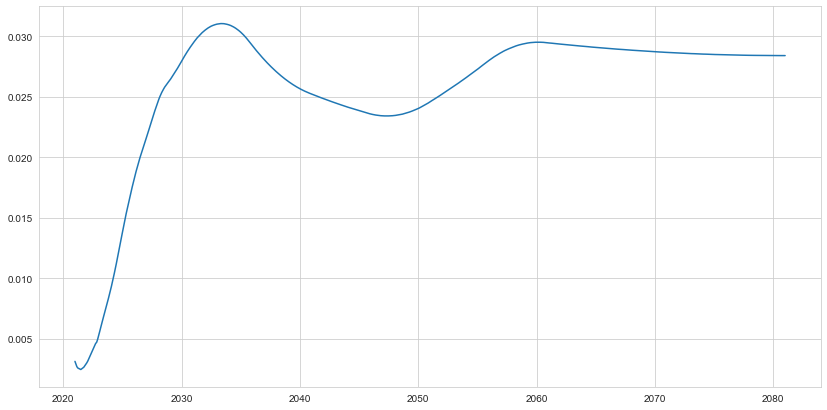

In [32]:
spot = euribor6m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Months) for i in range(0, 60 * 12 + 1)]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                     ql.Actual360(), ql.Simple).rate()
         for d in dates]
plt.figure(figsize=(14, 7))
plt.plot(to_dates(dates), rates)

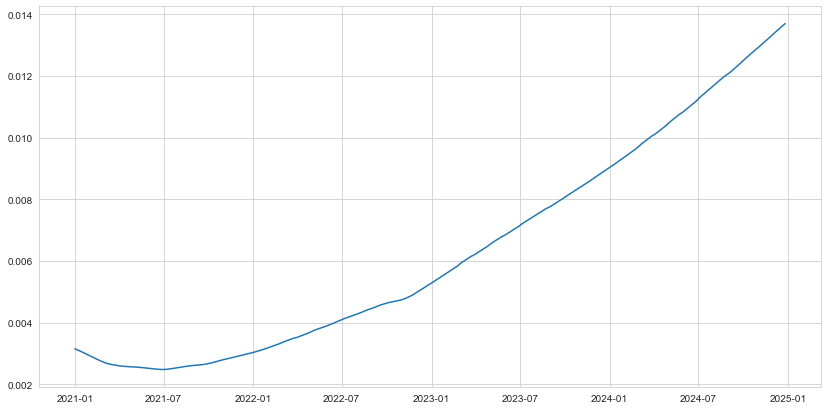

In [33]:
spot = euribor6m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 52 * 4 + 1)]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                     ql.Actual360(), ql.Simple).rate()
         for d in dates]
plt.figure(figsize=(14, 7))
plt.plot(to_dates(dates), rates)

In [34]:
euribor6m_curve_0 = euribor6m_curve